In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Some references
https://machinelearningmastery.com/xgboost-python-mini-course/  
https://www.kaggle.com/eikedehling/tune-and-compare-xgb-lightgbm-rf-with-hyperopt

# Dataset loading

In [2]:
dataset = pd.read_csv('../Y3 - Sample data/Z2 - datasetprepclean.csv', index_col = 0,
                     )
print('dataset shape:', dataset.shape)
dataset.head()

dataset shape: (5401, 795)


,cut_length,num_closed_patterns,num_open_patterns,total_area,minimum_rectangle_area,minimum_rectangle_dim1,minimum_rectangle_dim2,convex_hull_area,no_hole_area,thickness,...,bendlength_bend_edge_length_std_09,bendlength_bend_edge_length_min_09,bendlength_bend_edge_length_max_09,VAMAT,VALAJOUT,VALTOT,VOL_COST_CONVHULL,VOL_COST_RECTANGLE,VOL_COST_MPATTERN,bend_group
COART,,,,,,,,,,,,,,,,,,,,,
L1600360,3178.489502,9,0,285678.093750,431798.46875,722.070984,598.000000,320484.593750,286893.718750,4.0,...,0.0,0.0,0.0,12.51,5.15,17.66,0.000010,0.000007,0.000011,3-5
L1600470,317.114502,1,0,3403.138184,3500.00000,140.000000,25.000000,3403.138184,3403.138184,10.0,...,0.0,0.0,0.0,0.25,0.92,1.17,0.000007,0.000007,0.000007,0
L1600600,3710.627930,1,0,522587.812500,522587.81250,1509.000000,346.313995,522587.812500,522587.812500,3.0,...,0.0,0.0,0.0,18.36,7.55,25.91,0.000012,0.000012,0.000012,1-2
L1600610,3232.627930,1,0,439818.781250,439818.78125,1270.000000,346.313995,439818.781250,439818.781250,3.0,...,0.0,0.0,0.0,9.18,4.77,13.95,0.000007,0.000007,0.000007,1-2
L1600620,2972.627930,1,0,394797.968750,394797.96875,1140.000000,346.313995,394797.968750,394797.968750,3.0,...,0.0,0.0,0.0,9.18,4.65,13.83,0.000008,0.000008,0.000008,1-2


In [3]:
#dataset.columns.values

In [4]:
for index, nancount in dataset.isnull().sum().iteritems():
    if nancount != 0:
        print(index, '-->', nancount)
else:
    print('Done !')

dataset.shape

benddxf_deformation_length_00 --> 262
benddxf_deformation_length_01 --> 123
benddxf_deformation_length_02 --> 19
benddxf_deformation_length_03 --> 6
benddxf_deformation_length_04 --> 1
benddxf_deformation_length_05 --> 1
temp --> 5326
bendlength_deformation_length_00 --> 296
bendlength_deformation_length_01 --> 112
bendlength_deformation_length_02 --> 3
bendlength_deformation_length_03 --> 1
Done !


(5401, 795)

In [5]:
#Cleaning of the remaining Nan

subset = [x for x in dataset.columns.values if x.startswith('benddxf_')]

#dataset = dataset.fillna(0)
dataset = dataset.dropna(subset=subset)
dataset.shape

(5105, 795)

# cleaning to have at least min occurences

In [6]:
minocc = 50
todrop = []
df = dataset['thickness'].reset_index().groupby('thickness').count()
for index, occ in df.iterrows():
    if occ.COART <= minocc:
        print(occ.COART)
        todrop.append(index)
        print(index, 'will be dropped')

for thickness in todrop:
    dataset = dataset[dataset['thickness'] != thickness]

dataset.shape

33
1.5 will be dropped
1
2.5 will be dropped
6
20.0 will be dropped


(5065, 795)

# Target definition

In [7]:
target = 'VALTOT'
assert target in ['VAMAT', 'VALAJOUT', 'VALTOT'], 'The target must be in y dataset'

# Is the target "normal" ?

In [8]:
from scipy.stats import skew
skew(dataset[target]) #Nope !

4.11248507928211

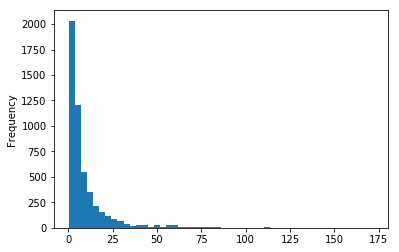

In [9]:
dataset[target].plot.hist(bins=50)
plt.show()

# Outlier tracking - VAMAT

In [10]:
toplimit = .95 #We drop the top 5%
botlimit = .02 #we drop the bottom 2%

In [11]:
#Surface cost calculation, quantile decomposition

#dataset['SURF_COST_CONVHULL'] = dataset['VAMAT'] / dataset['convex_hull_area']
#dataset['SURF_COST_RECTANGLE'] = dataset['VAMAT'] / dataset['minimum_rectangle_area']
dataset['SURF_COST_MPATTERN'] = dataset['VAMAT'] / dataset['no_hole_area']
#dataset['SURF_COST_TOTAREA'] = dataset['VAMAT'] / dataset['total_area']

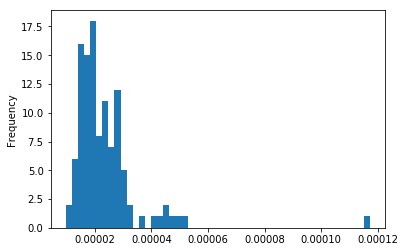

In [12]:
df = dataset[dataset['thickness'] == 2]
df['SURF_COST_MPATTERN'].plot.hist(bins=50)
plt.show()

In [13]:
#quantile decomposition
df=dataset[['thickness', 'SURF_COST_MPATTERN']].groupby('thickness').quantile([botlimit,toplimit])
df

SURF_COST_MPATTERN
thickness                         
2.0       0.02            0.000013
          0.95            0.000045
3.0       0.02            0.000018
          0.95            0.000060
4.0       0.02            0.000023
          0.95            0.000089
5.0       0.02            0.000028
          0.95            0.000091
6.0       0.02            0.000033
          0.95            0.000134
8.0       0.02            0.000044
          0.95            0.000182
10.0      0.02            0.000063
          0.95            0.000248
12.0      0.02            0.000059
          0.95            0.000247
15.0      0.02            0.000085
          0.95            0.000271

In [14]:
# If vamat is target, cleaning
if target == 'VAMAT' or target == 'VALTOT':
    for (thickness, limit), value in df.iterrows():
        tresh = value.values[0]
        if limit == botlimit:
            mask = np.logical_and(dataset['thickness'] == thickness, dataset[df.columns.values[0]] < tresh)
            dataset = dataset[np.logical_not(mask)]
        elif limit == toplimit:
            mask = np.logical_and(dataset['thickness'] == thickness, dataset[df.columns.values[0]] > tresh)
            dataset = dataset[np.logical_not(mask)]
        #print((thickness, limit), tresh)

dataset.shape

(4704, 796)

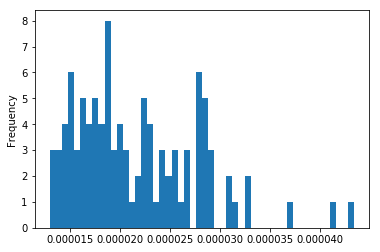

In [15]:
df = dataset[dataset['thickness'] == 2]
df['SURF_COST_MPATTERN'].plot.hist(bins=50)
plt.show()

In [16]:
skew(dataset[target])

3.8603967850964476

# Outlier tracking - VALAJOUT

In [17]:
toplimit = .95 #We drop the top 5%
botlimit = .02 #we drop the bottom 2%

In [18]:
#Cost per bend calculation

dataset['APPROX_BEND_COST'] = dataset['VALAJOUT'] / (dataset['bend_count']+1)

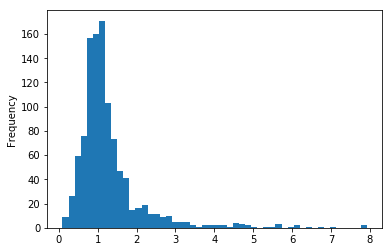

In [19]:
df = dataset[dataset['thickness'] == 6]
df['APPROX_BEND_COST'].plot.hist(bins=50)
plt.show()

In [20]:
#quantile decomposition
df=dataset[['thickness', 'APPROX_BEND_COST', 'bend_count']].groupby(['thickness', 'bend_count']).quantile([botlimit,toplimit])
df

APPROX_BEND_COST
thickness bend_count                       
2.0       0          0.02          0.704800
                     0.95          7.743000
          1          0.02          0.515800
                     0.95          2.330000
          2          0.02          0.245067
                     0.95          2.154667
          3          0.02          0.623350
                     0.95          1.954250
          4          0.02          0.573280
                     0.95          2.137800
          5          0.02          0.224867
                     0.95          2.048667
          6          0.02          0.703314
                     0.95          1.496000
          7          0.02          0.700500
                     0.95          1.551500
          8          0.02          0.782978
                     0.95          2.421111
          9          0.02          0.639000
                     0.95          0.639000
          14         0.02          0.502000
                     0.95          0.502000
3.0       0          0.02          0.218000
                     0.95          5.710000
          1          0.02          0.393500
                     0.95          1.483750
          2          0.02          0.405467
                     0.95          1.916500
          3          0.02          0.363850
                     0.95          2.401375
...                                     ...
10.0      0          0.02          0.592000
                     0.95          9.260000
          1          0.02          0.968600
                     0.95          4.102000
          2          0.02          0.489067
                     0.95          3.470000
          3          0.02          0.990350
                     0.95          3.877875
          4          0.02          1.137600
                     0.95          3.032000
          5          0.02          1.855000
                     0.95          1.855000
12.0      0          0.02          0.570000
                     0.95          6.860500
          1          0.02          0.165000
                     0.95          2.267500
          2          0.02          0.716667
                     0.95          1.723333
          3          0.02          0.615000
                     0.95          1.041000
          4          0.02          0.848240
                     0.95          1.819400
15.0      0          0.02          0.737000
                     0.95          8.658000
          1          0.02          1.100000
                     0.95          2.962250
          2          0.02          0.853333
                     0.95          1.526667
          3          0.02          0.870000
                     0.95          1.151250

[148 rows x 1 columns]

In [21]:
# If VALAJOUT is target, cleaning
if target == 'VALAJOUT' or target == 'VALTOT':
    for (thickness, bend_count, limit), value in df.iterrows():
        tresh = value.values[0]
        mask1 = np.logical_and(dataset['thickness'] == thickness, dataset['bend_count'] == bend_count)
        if limit == botlimit:
            mask = np.logical_and(mask1, dataset[df.columns.values[0]] < tresh)
            dataset = dataset[np.logical_not(mask)]
        elif limit == toplimit:
            mask = np.logical_and(mask1, dataset[df.columns.values[0]] > tresh)
            dataset = dataset[np.logical_not(mask)]
        #print((thickness, limit), tresh)

dataset.shape

(4316, 797)

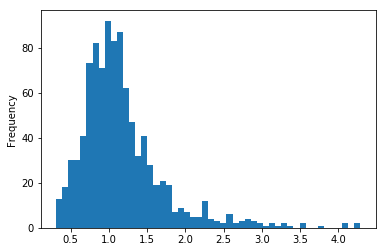

In [22]:
df = dataset[dataset['thickness'] == 6]
df['APPROX_BEND_COST'].plot.hist(bins=50)
plt.show()

## Target review

In [23]:
#Dataset definition
X = dataset
y = dataset[['VAMAT', 'VALAJOUT', 'VALTOT']]

,VALTOT
count,4316.000000
mean,7.457875
std,8.850946
min,0.370000
25%,2.560000
50%,4.480000
75%,9.040000
max,136.740000


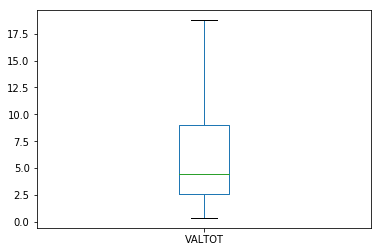

In [24]:
y[[target]].plot.box(sym='')
y[[target]].describe()

# Dataset re-ordering and Splitting

In [25]:
limitedset = ['cut_length', 'num_closed_patterns', 'num_open_patterns', 'total_area', 'minimum_rectangle_area',
              'minimum_rectangle_dim1', 'minimum_rectangle_dim2', 'convex_hull_area', 'no_hole_area',]

# 1 Bend as a float
limitedset.append('thickness')

# 2 Thickness as categories
#limitedset.extend([x for x in dataset.columns.values if x.startswith('thick_')])

# 3 Different counts
limitedset.extend(['radius_count', 'direction_count', 'bend_count'])

# 4 Bends in groups
#limitedset.extend([x for x in dataset.columns.values if x.startswith('bend_gr_')])

# 5 bends according DXF
#limitedset.extend([x for x in dataset.columns.values if x.startswith('benddxf_')])

# 6 according DXF, sorted by length
limitedset.extend([x for x in dataset.columns.values if x.startswith('bendlength_')])


print(len(limitedset))
limitedset

273


['cut_length',
 'num_closed_patterns',
 'num_open_patterns',
 'total_area',
 'minimum_rectangle_area',
 'minimum_rectangle_dim1',
 'minimum_rectangle_dim2',
 'convex_hull_area',
 'no_hole_area',
 'thickness',
 'radius_count',
 'direction_count',
 'bend_count',
 'bendlength_bend_radius_00',
 'bendlength_bend_angle_00',
 'bendlength_bend_direction_00',
 'bendlength_deformation_length_00',
 'bendlength_merged_bend_00',
 'bendlength_punch_length_00',
 'bendlength_bend_radius_01',
 'bendlength_bend_angle_01',
 'bendlength_bend_direction_01',
 'bendlength_deformation_length_01',
 'bendlength_merged_bend_01',
 'bendlength_punch_length_01',
 'bendlength_bend_radius_02',
 'bendlength_bend_angle_02',
 'bendlength_bend_direction_02',
 'bendlength_deformation_length_02',
 'bendlength_merged_bend_02',
 'bendlength_punch_length_02',
 'bendlength_bend_radius_03',
 'bendlength_bend_angle_03',
 'bendlength_bend_direction_03',
 'bendlength_deformation_length_03',
 'bendlength_merged_bend_03',
 'bendleng

In [26]:
# Dataset splitting
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0 ,stratify=dataset['bend_group'])

print(X_train.shape, X_test.shape)

#ONLY FOR DATASET CLEANING PURPOSE
#X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.5, random_state=0 ,stratify=dataset['bend_group'])

(3021, 797) (1295, 797)


# Box_cox feature creation

In [27]:
from scipy import stats
from scipy.special import inv_boxcox
_, lmbda = stats.boxcox(y_train[target], lmbda=None)
y_train['logtarget'] = y_train[target].apply(lambda x: stats.boxcox(x, lmbda))
y_test['logtarget'] = y_test[target].apply(lambda x: stats.boxcox(x, lmbda))

/Users/cricket/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/cricket/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


# Blocs creation

In [28]:
#Scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [29]:
# Metric MSE
from sklearn.metrics import mean_squared_error

In [30]:
# Metric MAE
from sklearn.metrics import mean_absolute_error

In [31]:
# Metric MAPE Mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

from sklearn.metrics import make_scorer
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
mape_scorer

make_scorer(mean_absolute_percentage_error, greater_is_better=False)

In [53]:
#regressions
import xgboost as xgb

xgb = xgb.XGBRegressor(eval_metric='rmse'
                       )

In [54]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [55]:
#Pipe definition
pipe = [('scaler', scaler), ('xgb', xgb)]

# Direct prediction

In [56]:
regpip = Pipeline(pipe)

In [57]:
regpip.fit(X_train[limitedset], y_train[target])

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('xgb', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='rmse', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1))])

In [77]:
param_grid = {
        #'xgb__max_depth':[0,6,10],
        'xgb__gamma':np.logspace(0,3,5),
        'xgb__min_child_weight':[1,3,5],
        'xgb__subsample':[1., .75, .5]
    }

#MSE version
gridxgb = GridSearchCV(regpip, param_grid, cv=3, n_jobs=-2, scoring='neg_mean_squared_error', verbose=5)

#MAPE version
#gridxgb = GridSearchCV(regpip, param_grid, cv=3, n_jobs=-2, scoring=mape_scorer, verbose=2)

In [78]:
gridxgb.fit(X_train[limitedset], y_train[target])

Fitting 3 folds for each of 45 candidates, totalling 135 fits
[CV] xgb__gamma=1.0, xgb__min_child_weight=1, xgb__subsample=1.0 .....
[CV] xgb__gamma=1.0, xgb__min_child_weight=1, xgb__subsample=1.0 .....
[CV] xgb__gamma=1.0, xgb__min_child_weight=1, xgb__subsample=1.0 .....
[CV]  xgb__gamma=1.0, xgb__min_child_weight=1, xgb__subsample=1.0, score=-7.945604350712571, total=   4.1s
[CV] xgb__gamma=1.0, xgb__min_child_weight=1, xgb__subsample=0.75 ....
[CV]  xgb__gamma=1.0, xgb__min_child_weight=1, xgb__subsample=1.0, score=-6.171019429073144, total=   4.0s
[CV]  xgb__gamma=1.0, xgb__min_child_weight=1, xgb__subsample=1.0, score=-2.9461597043817602, total=   4.0s
[CV] xgb__gamma=1.0, xgb__min_child_weight=1, xgb__subsample=0.75 ....
[CV] xgb__gamma=1.0, xgb__min_child_weight=1, xgb__subsample=0.75 ....
[CV]  xgb__gamma=1.0, xgb__min_child_weight=1, xgb__subsample=0.75, score=-8.196912032330951, total=   3.5s
[CV]  xgb__gamma=1.0, xgb__min_child_weight=1, xgb__subsample=0.75, score=-6.35202

[Parallel(n_jobs=-2)]: Done  12 tasks      | elapsed:   15.4s


[CV]  xgb__gamma=1.0, xgb__min_child_weight=3, xgb__subsample=0.75, score=-8.312322301458236, total=   3.4s
[CV]  xgb__gamma=1.0, xgb__min_child_weight=3, xgb__subsample=0.75, score=-6.115232874435109, total=   3.4s
[CV] xgb__gamma=1.0, xgb__min_child_weight=3, xgb__subsample=0.5 .....
[CV]  xgb__gamma=1.0, xgb__min_child_weight=3, xgb__subsample=0.75, score=-3.5210209733818556, total=   3.4s
[CV] xgb__gamma=1.0, xgb__min_child_weight=3, xgb__subsample=0.5 .....
[CV] xgb__gamma=1.0, xgb__min_child_weight=3, xgb__subsample=0.5 .....
[CV]  xgb__gamma=1.0, xgb__min_child_weight=3, xgb__subsample=0.5, score=-9.722271246090198, total=   3.2s
[CV] xgb__gamma=1.0, xgb__min_child_weight=5, xgb__subsample=1.0 .....
[CV]  xgb__gamma=1.0, xgb__min_child_weight=3, xgb__subsample=0.5, score=-6.090151656858071, total=   3.3s
[CV] xgb__gamma=1.0, xgb__min_child_weight=5, xgb__subsample=1.0 .....
[CV]  xgb__gamma=1.0, xgb__min_child_weight=3, xgb__subsample=0.5, score=-3.936421991658007, total=   3.3s

[CV] xgb__gamma=31.622776601683793, xgb__min_child_weight=1, xgb__subsample=0.75 
[CV]  xgb__gamma=31.622776601683793, xgb__min_child_weight=1, xgb__subsample=1.0, score=-6.253190405511983, total=   3.9s
[CV] xgb__gamma=31.622776601683793, xgb__min_child_weight=1, xgb__subsample=0.75 
[CV]  xgb__gamma=31.622776601683793, xgb__min_child_weight=1, xgb__subsample=1.0, score=-3.2517189942900666, total=   4.1s
[CV] xgb__gamma=31.622776601683793, xgb__min_child_weight=1, xgb__subsample=0.75 
[CV]  xgb__gamma=31.622776601683793, xgb__min_child_weight=1, xgb__subsample=0.75, score=-8.529482510024721, total=   3.5s
[CV]  xgb__gamma=31.622776601683793, xgb__min_child_weight=1, xgb__subsample=0.75, score=-6.593032410891485, total=   3.5s
[CV] xgb__gamma=31.622776601683793, xgb__min_child_weight=1, xgb__subsample=0.5 
[CV] xgb__gamma=31.622776601683793, xgb__min_child_weight=1, xgb__subsample=0.5 
[CV]  xgb__gamma=31.622776601683793, xgb__min_child_weight=1, xgb__subsample=0.75, score=-3.407416120

[Parallel(n_jobs=-2)]: Done  66 tasks      | elapsed:  1.4min


[CV]  xgb__gamma=31.622776601683793, xgb__min_child_weight=3, xgb__subsample=0.75, score=-8.241483770219169, total=   3.7s
[CV] xgb__gamma=31.622776601683793, xgb__min_child_weight=3, xgb__subsample=0.5 
[CV]  xgb__gamma=31.622776601683793, xgb__min_child_weight=3, xgb__subsample=0.75, score=-6.244332941461331, total=   3.7s
[CV] xgb__gamma=31.622776601683793, xgb__min_child_weight=3, xgb__subsample=0.5 
[CV]  xgb__gamma=31.622776601683793, xgb__min_child_weight=3, xgb__subsample=0.75, score=-3.619790425400785, total=   3.7s
[CV] xgb__gamma=31.622776601683793, xgb__min_child_weight=3, xgb__subsample=0.5 
[CV]  xgb__gamma=31.622776601683793, xgb__min_child_weight=3, xgb__subsample=0.5, score=-9.778001164026985, total=   3.3s
[CV] xgb__gamma=31.622776601683793, xgb__min_child_weight=5, xgb__subsample=1.0 
[CV]  xgb__gamma=31.622776601683793, xgb__min_child_weight=3, xgb__subsample=0.5, score=-6.306059134602561, total=   3.3s
[CV] xgb__gamma=31.622776601683793, xgb__min_child_weight=5, xg

[CV] xgb__gamma=1000.0, xgb__min_child_weight=1, xgb__subsample=1.0 ..
[CV]  xgb__gamma=177.82794100389228, xgb__min_child_weight=5, xgb__subsample=0.5, score=-4.898129503898384, total=   3.1s
[CV] xgb__gamma=1000.0, xgb__min_child_weight=1, xgb__subsample=1.0 ..
[CV] xgb__gamma=1000.0, xgb__min_child_weight=1, xgb__subsample=1.0 ..
[CV]  xgb__gamma=1000.0, xgb__min_child_weight=1, xgb__subsample=1.0, score=-13.509836254783105, total=   4.0s
[CV] xgb__gamma=1000.0, xgb__min_child_weight=1, xgb__subsample=0.75 .
[CV]  xgb__gamma=1000.0, xgb__min_child_weight=1, xgb__subsample=1.0, score=-11.063550421509532, total=   4.0s
[CV]  xgb__gamma=1000.0, xgb__min_child_weight=1, xgb__subsample=1.0, score=-6.535936578645644, total=   4.0s
[CV] xgb__gamma=1000.0, xgb__min_child_weight=1, xgb__subsample=0.75 .
[CV] xgb__gamma=1000.0, xgb__min_child_weight=1, xgb__subsample=0.75 .
[CV]  xgb__gamma=1000.0, xgb__min_child_weight=1, xgb__subsample=0.75, score=-12.366689725370252, total=   3.5s
[CV]  xg

[Parallel(n_jobs=-2)]: Done 135 out of 135 | elapsed:  2.8min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('xgb', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='rmse', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=...ate=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1))]),
       fit_params=None, iid=True, n_jobs=-2,
       param_grid={'xgb__gamma': array([   1.     ,    5.62341,   31.62278,  177.82794, 1000.     ]), 'xgb__min_child_weight': [1, 3, 5], 'xgb__subsample': [1.0, 0.75, 0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=5)

In [79]:
target

'VALTOT'

In [80]:
gridxgb.best_params_

{'xgb__gamma': 5.623413251903491,
 'xgb__min_child_weight': 3,
 'xgb__subsample': 1.0}

In [81]:
gridxgb.best_score_

-5.469922359500602

In [82]:
mean_absolute_percentage_error(y_test[target], gridxgb.predict(X_test[limitedset]))

17.384285049363932

In [83]:
mean_squared_error(y_test[target], gridxgb.predict(X_test[limitedset]))

4.211157578468207

In [84]:
mean_squared_error(y_train[target], gridxgb.predict(X_train[limitedset]))

1.5933675063133832

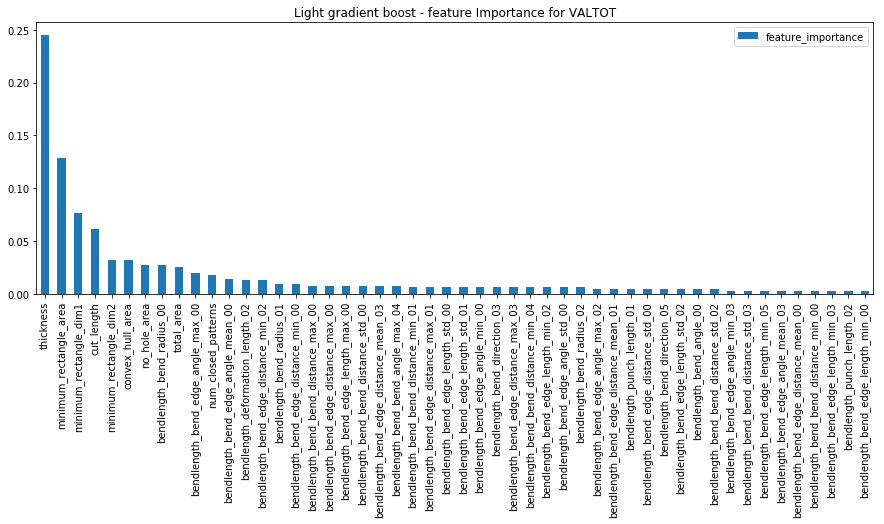

In [86]:
featimp = list(gridxgb.best_estimator_.named_steps['xgb'].feature_importances_)
df = pd.DataFrame({'feature_importance':featimp}, index =limitedset)
df = df.sort_values('feature_importance', ascending=False)
df[:50].plot.bar(figsize=(15,5))
plt.title(f'Light gradient boost - feature Importance for {target}')
plt.show()

# BOX-COX prediction

In [87]:
regpiplog = Pipeline(pipe)

In [88]:
regpiplog.fit(X_train[limitedset], y_train['logtarget'])

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('xgb', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='rmse', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1))])

In [89]:
param_grid = {
        #'xgb__max_depth':[0,6,10],
        'xgb__gamma':np.logspace(0,3,5),
        'xgb__min_child_weight':[1,3,5],
        'xgb__subsample':[1., .75, .5]
    }

#MSE version
gridxgblog = GridSearchCV(regpiplog, param_grid, cv=3, n_jobs=-2, scoring='neg_mean_absolute_error', verbose=5)

#MAPE version
#gridxgblog = GridSearchCV(regpiplog, param_grid, cv=3, n_jobs=-2, scoring=mape_scorer, verbose=2)

In [90]:
gridxgblog.fit(X_train[limitedset], y_train['logtarget'])

Fitting 3 folds for each of 45 candidates, totalling 135 fits
[CV] xgb__gamma=1.0, xgb__min_child_weight=1, xgb__subsample=1.0 .....
[CV] xgb__gamma=1.0, xgb__min_child_weight=1, xgb__subsample=1.0 .....
[CV] xgb__gamma=1.0, xgb__min_child_weight=1, xgb__subsample=1.0 .....
[CV]  xgb__gamma=1.0, xgb__min_child_weight=1, xgb__subsample=1.0, score=-0.12753477792057127, total=   2.4s
[CV] xgb__gamma=1.0, xgb__min_child_weight=1, xgb__subsample=0.75 ....
[CV]  xgb__gamma=1.0, xgb__min_child_weight=1, xgb__subsample=1.0, score=-0.12478849064715516, total=   2.4s
[CV] xgb__gamma=1.0, xgb__min_child_weight=1, xgb__subsample=0.75 ....
[CV]  xgb__gamma=1.0, xgb__min_child_weight=1, xgb__subsample=1.0, score=-0.12421684441259935, total=   2.5s
[CV] xgb__gamma=1.0, xgb__min_child_weight=1, xgb__subsample=0.75 ....
[CV]  xgb__gamma=1.0, xgb__min_child_weight=1, xgb__subsample=0.75, score=-0.12533021942661557, total=   2.1s
[CV] xgb__gamma=1.0, xgb__min_child_weight=1, xgb__subsample=0.5 .....
[CV]

[Parallel(n_jobs=-2)]: Done  12 tasks      | elapsed:    9.4s


[CV] xgb__gamma=1.0, xgb__min_child_weight=3, xgb__subsample=0.75 ....
[CV] xgb__gamma=1.0, xgb__min_child_weight=3, xgb__subsample=0.75 ....
[CV] xgb__gamma=1.0, xgb__min_child_weight=3, xgb__subsample=0.75 ....
[CV]  xgb__gamma=1.0, xgb__min_child_weight=3, xgb__subsample=0.75, score=-0.12533021942661557, total=   2.5s
[CV] xgb__gamma=1.0, xgb__min_child_weight=3, xgb__subsample=0.5 .....
[CV]  xgb__gamma=1.0, xgb__min_child_weight=3, xgb__subsample=0.75, score=-0.12279851014285004, total=   2.5s
[CV] xgb__gamma=1.0, xgb__min_child_weight=3, xgb__subsample=0.5 .....
[CV]  xgb__gamma=1.0, xgb__min_child_weight=3, xgb__subsample=0.75, score=-0.12143256536693768, total=   2.3s
[CV] xgb__gamma=1.0, xgb__min_child_weight=3, xgb__subsample=0.5 .....
[CV]  xgb__gamma=1.0, xgb__min_child_weight=3, xgb__subsample=0.5, score=-0.12792438325826336, total=   2.2s
[CV] xgb__gamma=1.0, xgb__min_child_weight=5, xgb__subsample=1.0 .....
[CV]  xgb__gamma=1.0, xgb__min_child_weight=3, xgb__subsample=0.

[CV]  xgb__gamma=5.623413251903491, xgb__min_child_weight=5, xgb__subsample=0.5, score=-0.16927053941019482, total=   2.0s
[CV] xgb__gamma=31.622776601683793, xgb__min_child_weight=1, xgb__subsample=1.0 
[CV]  xgb__gamma=31.622776601683793, xgb__min_child_weight=1, xgb__subsample=1.0, score=-0.25811419773678096, total=   2.4s
[CV] xgb__gamma=31.622776601683793, xgb__min_child_weight=1, xgb__subsample=0.75 
[CV]  xgb__gamma=31.622776601683793, xgb__min_child_weight=1, xgb__subsample=1.0, score=-0.2502015160490207, total=   2.4s
[CV]  xgb__gamma=31.622776601683793, xgb__min_child_weight=1, xgb__subsample=1.0, score=-0.2386699281053212, total=   2.4s
[CV] xgb__gamma=31.622776601683793, xgb__min_child_weight=1, xgb__subsample=0.75 
[CV] xgb__gamma=31.622776601683793, xgb__min_child_weight=1, xgb__subsample=0.75 
[CV]  xgb__gamma=31.622776601683793, xgb__min_child_weight=1, xgb__subsample=0.75, score=-0.26035572699365633, total=   2.1s
[CV] xgb__gamma=31.622776601683793, xgb__min_child_weig

[Parallel(n_jobs=-2)]: Done  66 tasks      | elapsed:   51.6s


[CV]  xgb__gamma=31.622776601683793, xgb__min_child_weight=3, xgb__subsample=0.75, score=-0.26035572699365633, total=   2.2s
[CV] xgb__gamma=31.622776601683793, xgb__min_child_weight=3, xgb__subsample=0.5 
[CV]  xgb__gamma=31.622776601683793, xgb__min_child_weight=3, xgb__subsample=0.75, score=-0.25871741126529824, total=   2.1s
[CV] xgb__gamma=31.622776601683793, xgb__min_child_weight=3, xgb__subsample=0.5 
[CV]  xgb__gamma=31.622776601683793, xgb__min_child_weight=3, xgb__subsample=0.75, score=-0.25904666609769034, total=   2.2s
[CV] xgb__gamma=31.622776601683793, xgb__min_child_weight=3, xgb__subsample=0.5 
[CV]  xgb__gamma=31.622776601683793, xgb__min_child_weight=3, xgb__subsample=0.5, score=-0.28163675217372497, total=   2.0s
[CV]  xgb__gamma=31.622776601683793, xgb__min_child_weight=3, xgb__subsample=0.5, score=-0.2913779146985252, total=   2.0s
[CV]  xgb__gamma=31.622776601683793, xgb__min_child_weight=3, xgb__subsample=0.5, score=-0.28778140510113565, total=   2.0s
[CV] xgb__g

[CV] xgb__gamma=1000.0, xgb__min_child_weight=1, xgb__subsample=1.0 ..
[CV]  xgb__gamma=177.82794100389228, xgb__min_child_weight=5, xgb__subsample=0.5, score=-0.4388291161362141, total=   3.3s
[CV] xgb__gamma=1000.0, xgb__min_child_weight=1, xgb__subsample=1.0 ..
[CV] xgb__gamma=1000.0, xgb__min_child_weight=1, xgb__subsample=1.0 ..
[CV]  xgb__gamma=1000.0, xgb__min_child_weight=1, xgb__subsample=1.0, score=-0.6211350620436817, total=   3.9s
[CV] xgb__gamma=1000.0, xgb__min_child_weight=1, xgb__subsample=0.75 .
[CV]  xgb__gamma=1000.0, xgb__min_child_weight=1, xgb__subsample=1.0, score=-0.6546832697037055, total=   3.9s
[CV]  xgb__gamma=1000.0, xgb__min_child_weight=1, xgb__subsample=1.0, score=-0.6232258901838151, total=   3.9s
[CV] xgb__gamma=1000.0, xgb__min_child_weight=1, xgb__subsample=0.75 .
[CV] xgb__gamma=1000.0, xgb__min_child_weight=1, xgb__subsample=0.75 .
[CV]  xgb__gamma=1000.0, xgb__min_child_weight=1, xgb__subsample=0.75, score=-0.6211051406303851, total=   3.5s
[CV]  

[Parallel(n_jobs=-2)]: Done 135 out of 135 | elapsed:  2.0min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('xgb', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='rmse', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=...ate=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1))]),
       fit_params=None, iid=True, n_jobs=-2,
       param_grid={'xgb__gamma': array([   1.     ,    5.62341,   31.62278,  177.82794, 1000.     ]), 'xgb__min_child_weight': [1, 3, 5], 'xgb__subsample': [1.0, 0.75, 0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=5)

In [91]:
target

'VALTOT'

In [92]:
gridxgblog.best_params_

{'xgb__gamma': 1.0, 'xgb__min_child_weight': 1, 'xgb__subsample': 0.75}

In [93]:
mean_absolute_percentage_error(y_test[target], inv_boxcox(gridxgblog.predict(X_test[limitedset]), lmbda))

14.769476349500174

In [94]:
mean_squared_error(y_test[target], inv_boxcox(gridxgblog.predict(X_test[limitedset]), lmbda))

7.168258509936229

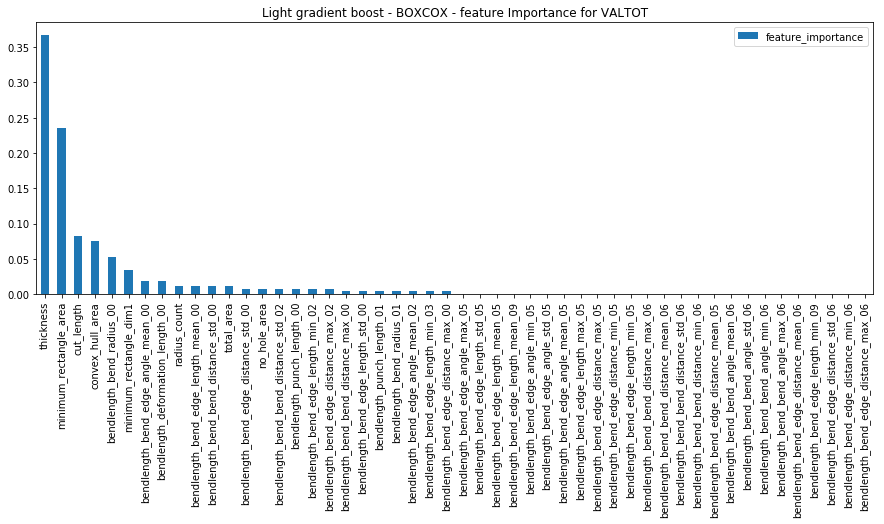

In [95]:
featimp = list(gridxgblog.best_estimator_.named_steps['xgb'].feature_importances_)
df = pd.DataFrame({'feature_importance':featimp}, index =limitedset)
df = df.sort_values('feature_importance', ascending=False)
df[:50].plot.bar(figsize=(15,5))
plt.title(f'Light gradient boost - BOXCOX - feature Importance for {target}')
plt.show()

# Solution comparison

In [96]:
prediction_xgb = gridxgb.predict(X_test[limitedset])
prediction_xgb_log = inv_boxcox(gridxgblog.predict(X_test[limitedset]), lmbda)

In [98]:
resultset = pd.DataFrame({f'target': y_test[target],
                          'prediction_xgb':prediction_xgb,
                          'prediction_xgb_log':prediction_xgb_log,
                            }, index=y_test.index)
resultset.head()

,prediction_xgb,prediction_xgb_log,target
COART,,,
L3104170,6.247589,6.363876,8.13
L8826140,2.285673,2.537072,2.42
L1615860,0.984061,0.984656,1.04
L8055440,4.405120,4.155797,4.55
L8042170,3.294612,3.363893,3.74


In [99]:
#Solution saving
resultset.to_csv(f'{target}_pred_xgb.csv')


In [100]:
#MAPE
mape = mean_absolute_percentage_error(resultset['target'], resultset['prediction_xgb'])
mapelog = mean_absolute_percentage_error(resultset['target'], resultset['prediction_xgb_log'])
print('mape', mape)
print('mapelog', mapelog)

mape 17.384285049363932
mapelog 14.769476349500174


In [101]:
#MSE
mse = mean_squared_error(resultset['target'], resultset['prediction_xgb'])
mselog = mean_squared_error(resultset['target'], resultset['prediction_xgb_log'])
print('mse', mse)
print('mselog', mselog)

mse 4.211157578468207
mselog 7.168258509936229


In [108]:
resultset['MSE_xgb'] = (resultset['target']-resultset['prediction_xgb'])**2
resultset['MSE_log_xgb'] = (resultset['target']-resultset['prediction_xgb_log'])**2
resultset.head()

,prediction_xgb,prediction_xgb_log,target,MSE_xgb,MSE_xgb_lgbm,MSE_log_xgb
COART,,,,,,
L3104170,6.247589,6.363876,8.13,3.543471,3.119193,3.119193
L8826140,2.285673,2.537072,2.42,0.018044,0.013706,0.013706
L1615860,0.984061,0.984656,1.04,0.003129,0.003063,0.003063
L8055440,4.405120,4.155797,4.55,0.020990,0.155396,0.155396
L8042170,3.294612,3.363893,3.74,0.198370,0.141456,0.141456


In [109]:
resultset['MSE_xgb'].mean()

4.211157578468212

In [110]:
#Data assembly
comparisonset = pd.merge(resultset.reset_index(), X_test.reset_index(), on='COART', how='inner')
comparisonset.head()

,COART,prediction_xgb,prediction_xgb_log,target,MSE_xgb,MSE_xgb_lgbm,MSE_log_xgb,cut_length,num_closed_patterns,num_open_patterns,...,bendlength_bend_edge_length_max_09,VAMAT,VALAJOUT,VALTOT,VOL_COST_CONVHULL,VOL_COST_RECTANGLE,VOL_COST_MPATTERN,bend_group,SURF_COST_MPATTERN,APPROX_BEND_COST
0,L3104170,6.247589,6.363876,8.13,3.543471,3.119193,3.119193,1986.643677,10,0,...,0.0,4.41,3.72,8.13,0.000011,0.000008,0.000014,0,0.000070,3.720
1,L8826140,2.285673,2.537072,2.42,0.018044,0.013706,0.013706,496.880127,3,0,...,0.0,0.44,1.98,2.42,0.000006,0.000006,0.000006,1-2,0.000036,0.990
2,L1615860,0.984061,0.984656,1.04,0.003129,0.003063,0.003063,391.016144,2,0,...,0.0,0.24,0.80,1.04,0.000009,0.000007,0.000009,0,0.000044,0.800
3,L8055440,4.405120,4.155797,4.55,0.020990,0.155396,0.155396,776.781677,2,0,...,0.0,2.00,2.55,4.55,0.000008,0.000006,0.000008,1-2,0.000079,1.275
4,L8042170,3.294612,3.363893,3.74,0.198370,0.141456,0.141456,858.618835,2,0,...,0.0,2.06,1.68,3.74,0.000012,0.000010,0.000012,1-2,0.000074,0.840


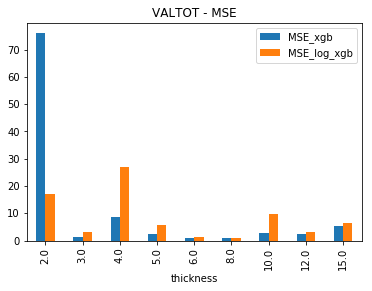

,MSE_xgb,MSE_log_xgb,COART
,mean,mean,count
thickness,,,
2.0,75.953531,17.103326,26
3.0,1.222135,3.124496,106
4.0,8.599170,26.995305,187
5.0,2.222396,5.577669,142
6.0,0.996778,1.308448,299
8.0,0.852807,0.954921,243
10.0,2.878915,9.564436,149
12.0,2.434110,3.172853,91


In [111]:
# Is the error sourced by thickness ?
df = comparisonset[['MSE_xgb', 'MSE_log_xgb', 'thickness']].groupby('thickness').mean()
df.plot.bar()
plt.title(f'{target} - MSE')
plt.show()
comparisonset.groupby('thickness').agg({'MSE_xgb':['mean'],
                                        'MSE_log_xgb':['mean'],
                                         'COART':['count']})

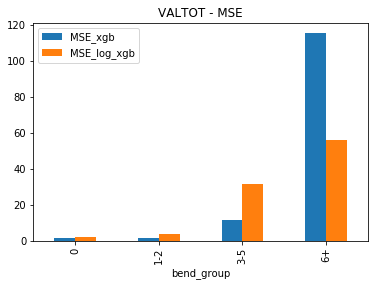

,MSE_xgb,MSE_log_xgb,COART
,mean,mean,count
bend_group,,,
0,1.606468,2.159408,535
1-2,1.248674,3.443804,579
3-5,11.645491,31.598130,164
6+,115.361538,55.973845,17


In [112]:
# Is the error sourced by number of errors ?

df = comparisonset[['MSE_xgb', 'MSE_log_xgb', 'bend_group']].groupby('bend_group').mean()
df.plot.bar()
plt.title(f'{target} - MSE')
plt.show()
comparisonset.groupby('bend_group').agg({'MSE_xgb':['mean'],
                                         'MSE_log_xgb':['mean'],
                                         'COART':['count']})

In [113]:
comparisonset['MAPE_error'] = comparisonset.apply(lambda x: mean_absolute_percentage_error(x['target'], x['prediction_xgb']), axis=1)
comparisonset['MAPE_log_error'] = comparisonset.apply(lambda x: mean_absolute_percentage_error(x['target'], x['prediction_xgb_log']), axis=1)

comparisonset[['target', 'prediction_xgb', 'MAPE_error', 'prediction_xgb_log', 'MAPE_log_error']].head()

,target,prediction_xgb,MAPE_error,prediction_xgb_log,MAPE_log_error
0,8.13,6.247589,23.153885,6.363876,21.723538
1,2.42,2.285673,5.550716,2.537072,4.837674
2,1.04,0.984061,5.378704,0.984656,5.321524
3,4.55,4.405120,3.184178,4.155797,8.663792
4,3.74,3.294612,11.908759,3.363893,10.056330


In [114]:
#MAPE
comparisonset['MAPE_error'].mean()

17.384285049363946

In [115]:
#If bends use this line
if target == 'VALAJOUT' or target == 'VALTOT':
    df = comparisonset[['MSE_xgb', 'MSE_log_xgb','MAPE_error', 'MAPE_log_error', 'thickness', 'bend_group', 'COART']].groupby(['thickness', 'bend_group'])

#If no bends use this line
if target == 'VAMAT':
    df = comparisonset[['MSE_xgb', 'MSE_log_xgb','MAPE_error', 'MAPE_log_error', 'thickness', 'COART']].groupby(['thickness'])

df.agg({'MSE_xgb': ['mean', 'max'],
        'MSE_log_xgb': ['mean', 'max'],
        'MAPE_error': ['mean', 'max'],
        'MAPE_log_error': ['mean', 'max'],
        'COART':['count'] })

MSE_xgb              MSE_log_xgb               \
                            mean          max        mean          max   
thickness bend_group                                                     
2.0       1-2           0.789930     1.693163    0.232870     0.679596   
          3-5          17.242817    86.373885    3.081754    13.555771   
          6+          299.077386  1618.569437   68.590038   140.057622   
3.0       0             1.042926     3.446628    0.786186     3.971871   
          1-2           0.586236     3.504257    1.179674    10.381570   
          3-5           1.685345     9.964715    5.681131    96.920306   
          6+            4.577101    11.883075   14.762025    33.267529   
4.0       0             1.864336    38.237013    1.263442    12.127006   
          1-2           1.340001    36.262120    4.973936   442.300435   
          3-5          35.270152  1101.728280  113.862885  4183.234154   
          6+            6.793769    12.931602    4.135170    12.360032   
5.0       0             0.377752     3.543471    0.274750     3.119193   
          1-2           1.308554    44.631689    2.175517    52.015837   
          3-5           4.535195    31.335906    9.184311    97.913009   
          6+           40.861986   121.612766  153.272913   416.001835   
6.0       0             0.364592     7.914792    0.339986    10.743146   
          1-2           0.686750    15.235957    0.690600    14.012579   
          3-5           4.039741    54.468308    6.527176    70.464055   
          6+            5.406164     5.406164    8.742786     8.742786   
8.0       0             0.762397    25.696047    0.910845    26.371251   
          1-2           0.849314    14.088201    0.838951    23.636774   
          3-5           1.613998     7.100376    2.011610    14.159174   
10.0      0             2.333499    63.447640    4.865210   219.105076   
          1-2           3.150066    60.103856   15.229764   221.464776   
          3-5           5.959341    22.759792    9.471856    31.662483   
12.0      0             2.690693    40.712723    3.633787    48.223933   
          1-2           1.856798     7.033996    2.135752    17.784271   
15.0      0             5.806687    78.519725    7.067187   100.898044   
          1-2           1.216222     4.637445    1.871973     8.421677   
          3-5           1.156587     1.156587    0.503095     0.503095   

                     MAPE_error             MAPE_log_error             COART  
                           mean         max           mean         max count  
thickness bend_group                                                          
2.0       1-2         30.444858   59.044475      16.749340   66.481945    10  
          3-5         17.172067   31.534430      15.337275   26.451080    10  
          6+          42.007536  165.561516      27.932349   48.842733     6  
3.0       0           31.277600  125.440359      28.758649  132.208443    26  
          1-2         16.697970   63.519042      15.069473   56.129915    40  
          3-5         12.247693   40.387545      15.076572   34.748703    36  
          6+           9.397242   24.190762      14.084572   32.155689     4  
4.0       0           36.372762   81.731619      28.809258   82.198269    34  
          1-2         19.336137   78.954547      16.864408   84.497381   111  
          3-5         15.827553   65.714301      16.970220   59.321220    39  
          6+          29.487357   38.708866      14.005766   37.843743     3  
5.0       0           26.714459  130.832725      21.000187  105.361538    47  
          1-2         14.202489   52.197496      13.191193   67.895570    75  
          3-5         14.120631   49.494680      11.887309   29.414686    17  
          6+           7.697981   17.896491      22.688871   33.099843     3  
6.0       0           17.729399  138.143102      13.966710   95.912576   112  
          1-2         11.360149   63.876042      11.273351   65.962428   149  
  

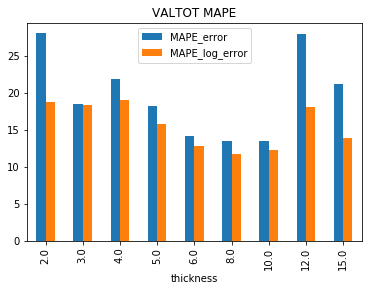

,MAPE_error,MAPE_log_error,COART
,mean,mean,count
thickness,,,
2.0,28.008249,18.786933,26
3.0,18.487191,18.392440,106
4.0,21.864822,19.012406,187
5.0,18.196556,15.820416,142
6.0,14.156136,12.829248,299
8.0,13.476723,11.739380,243
10.0,13.461875,12.294328,149
12.0,27.898566,18.037515,91


In [116]:
df = comparisonset[['MAPE_error', 'MAPE_log_error', 'thickness']].groupby('thickness').mean()
df.plot.bar()
plt.title(f'{target} MAPE')
plt.show()
comparisonset.groupby('thickness').agg({'MAPE_error':['mean'],
                                         'MAPE_log_error':['mean'],
                                         'COART':['count']})

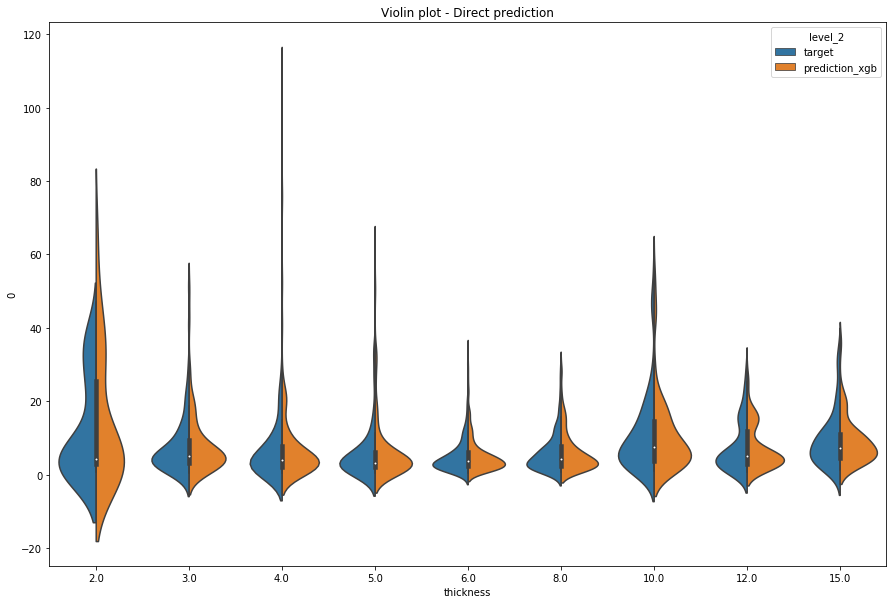

In [117]:
#Violin plot
df=comparisonset[['target', 'prediction_xgb', 'COART', 'thickness']]
#df=df[df['thickness']!=15]
df.set_index(['COART', 'thickness'], inplace=True)
df = df.stack().reset_index()
fig, ax = plt.subplots(figsize=(15,10))
#ax.set_ylim(-100, 100)
sns.violinplot(x="thickness", y=0, data=df, split=True, hue='level_2', ax=ax)
plt.title('Violin plot - Direct prediction')
plt.show()

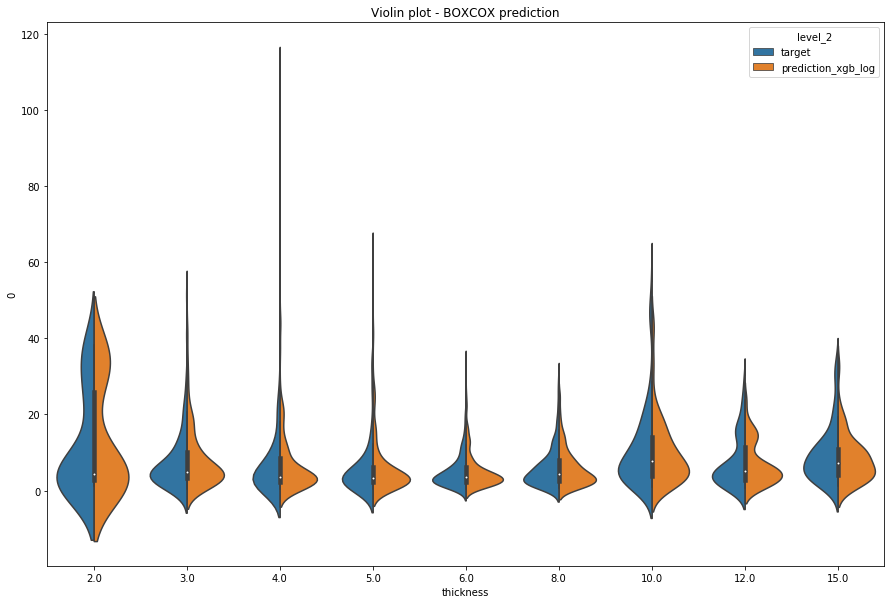

In [118]:
#Violin plot
df=comparisonset[['target', 'prediction_xgb_log', 'COART', 'thickness']]
#df=df[df['thickness']!=15]
df.set_index(['COART', 'thickness'], inplace=True)
df = df.stack().reset_index()
fig, ax = plt.subplots(figsize=(15,10))
#ax.set_ylim(-100, 100)
sns.violinplot(x="thickness", y=0, data=df, split=True, hue='level_2', ax=ax)
plt.title('Violin plot - BOXCOX prediction')
plt.show()

/Users/cricket/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


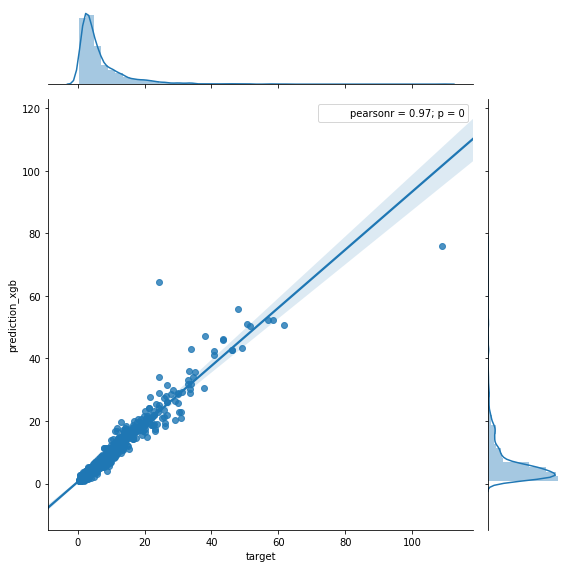

In [120]:
# No BOXCOX
sns.jointplot(x='target', y='prediction_xgb', data=comparisonset, kind='reg', size=8)
plt.show()

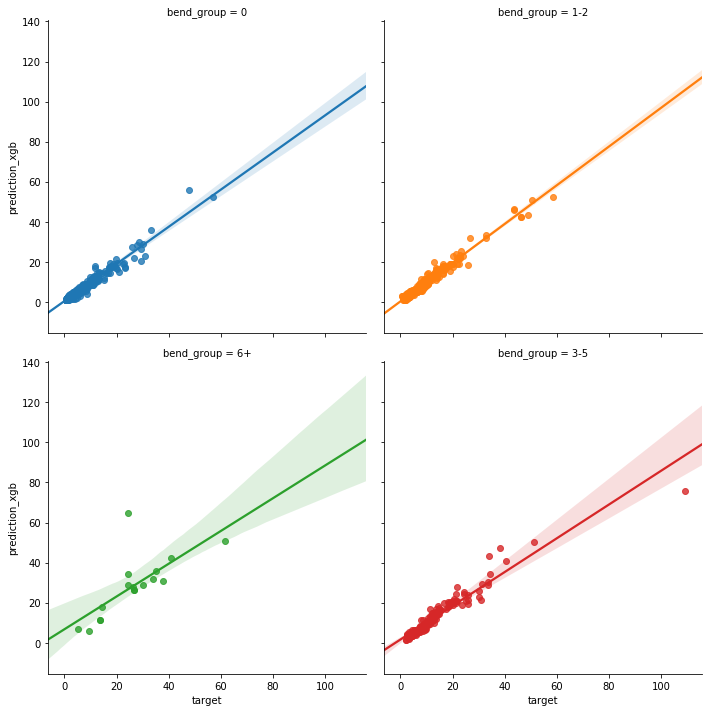

In [121]:
sns.lmplot(x='target',
           y='prediction_xgb',
           col='bend_group',
           hue='bend_group',
           data=comparisonset,
           aspect=1,
           col_wrap=2,
           size=5,
           legend=True)
plt.show()

/Users/cricket/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


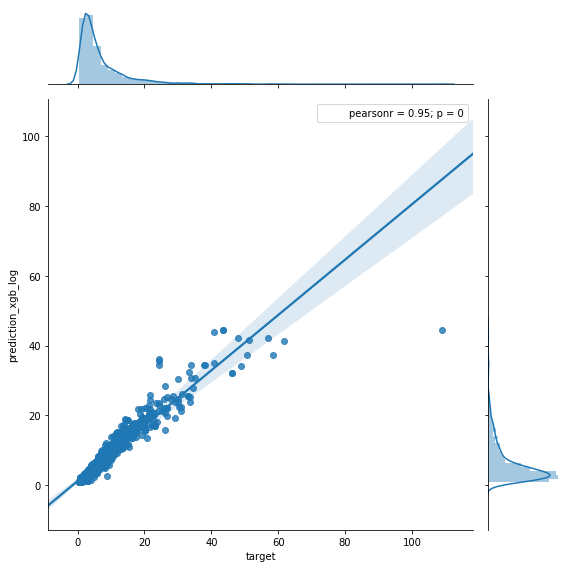

In [122]:
# With BOXCOX
sns.jointplot(x='target', y='prediction_xgb_log', data=comparisonset, kind='reg',size=8)
plt.show()

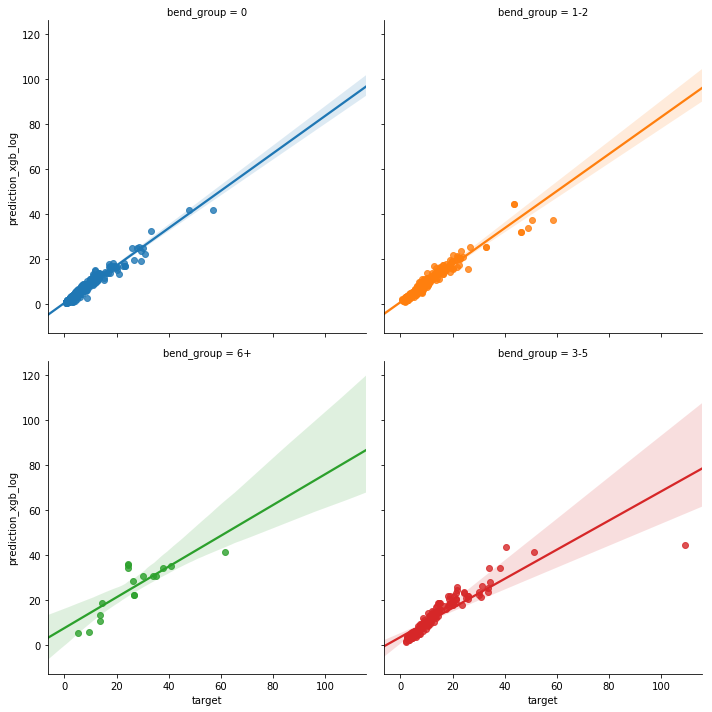

In [123]:
sns.lmplot(x='target',
           y='prediction_xgb_log',
           col='bend_group',
           hue='bend_group',
           data=comparisonset,
           aspect=1,
           col_wrap=2,
           size=5,
           #palette="Set1",
           legend=True),
plt.show()

In [124]:
df = comparisonset[['MSE_xgb', 'COART', 'thickness']]
df.set_index('COART', inplace=True)
worst = df.groupby('thickness')['MSE_xgb'].nlargest(5)

worst.to_csv('../Y3 - Sample data/Z3 - outliers.csv')
print(worst.shape)
worst

(45,)


thickness  COART   
2.0        L7067210    1618.569437
           L5606430      97.169678
           L6012920      86.373885
           L6003820      81.421527
           L5606410      52.447326
3.0        L8033191      11.883075
           L8041050       9.964715
           L7069470       8.847992
           L8416790       8.236094
           L7069460       7.314048
4.0        L1608630    1101.728280
           L6006670      98.310080
           L8808960      46.264183
           L8833310      38.237013
           L7074570      36.262120
5.0        L3122540     121.612766
           L7018061      44.631689
           L2608480      31.335906
           L8807850      25.022720
           L7065860      12.013951
6.0        L6000541      54.468308
           L8816941      22.493697
           L2605990      17.614120
           L7068571      15.235957
           L7026880       7.967882
8.0        L7080990      25.696047
           L7081680      14.088201
           L3128850      10.499202


In [ ]:
#comparison

#Thickness filter
df = comparisonset[comparisonset['thickness'] == 8]

#Cost filter Max
#df = df[df[target]<15]

#Cost filter Min
#df = df[df[target]>10] #bend_count

#Min rectangle area
#df = df[df['minimum_rectangle_area'] < 700000]
df = df[df['minimum_rectangle_area'] > 10000]

#bend_count filter
df = df[df['bend_count'] == 4]

#df[df['COART']=='L3128890'].T
df.T

In [ ]:
dataset.loc[['L8835850']].T
#comparisonset[comparisonset['COART'] == 'L3131690']

# Summing solution :  
VALTOT = VAMAT + VALAJOUT

In [ ]:
resultset.head()

In [ ]:
VAMAT = pd.read_csv('VAMAT_pred_lgbm.csv')
VAMAT.columns = ['COART', 'VAMAT_pred']
VALAJOUT = pd.read_csv('VALAJOUT_pred_lgbm.csv')
VALAJOUT.columns = ['COART', 'VALAJOUT_pred']
print(VAMAT.shape, VALAJOUT.shape)

In [ ]:
sumset = pd.merge(resultset.reset_index(), VAMAT, on='COART', how='inner')
sumset = pd.merge(sumset, VALAJOUT, on='COART', how='inner')

sumset.shape

In [ ]:
sumset['VALTOT_sum'] = sumset['VAMAT_pred'] + sumset['VALAJOUT_pred']
sumset.head()

In [ ]:
mean_absolute_percentage_error(sumset['target'], sumset['VALTOT_sum'])

In [ ]:
mean_squared_error(sumset['target'], sumset['VALTOT_sum'])

In [ ]:
sns.jointplot(x='target', y='VALTOT_sum', data=sumset, kind='reg', size=8)

# Hyper Opt

In [ ]:
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from sklearn.model_selection import cross_val_score

https://github.com/hyperopt/hyperopt/wiki/FMin

In [ ]:

scaler = StandardScaler()
Xtr_scaled = scaler.fit_transform(X_train[limitedset])
Xte_scaled = scaler.transform(X_test[limitedset])

In [ ]:
def objective(params):
    params = {
        'num_leaves': int(params['num_leaves']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
        'max_depth': int(params['num_leaves']),
        'min_split_gain': params['min_split_gain'],
        'reg_alpha': params['reg_alpha'],
        #'reg_lambda': params['reg_lambda'],
        'min_child_weight': int(params['min_child_weight']),
        'learning_rate':params['learning_rate'],
        
    }
    
    clf = lgb.LGBMRegressor(objective='regression',
        n_estimators=500,
        **params
    )
    
    score = cross_val_score(clf, Xtr_scaled, y_train[target], scoring='neg_mean_squared_error', cv=3).mean()
    print("MSE {:.3f} params {}".format(score, params))
    return score

space = {
    'num_leaves': hp.quniform('num_leaves', 8, 128, 2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.01, 1.0),
    'max_depth': hp.uniform('max_depth', 1000, 1500),
    'min_split_gain': hp.uniform('min_split_gain', 0, 10),
    'reg_alpha': hp.loguniform('reg_alpha', -3, 3),
    #'reg_lambda': hp.loguniform('reg_lambda', -3, 3),
    'min_child_weight': hp.uniform('min_child_weight', 0, 20),
    'learning_rate': hp.uniform('learning_rate', 0.001, 1.0),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)

In [ ]:
print("Hyperopt estimated optimum {}".format(best))

In [ ]:
gbm = lgb.LGBMRegressor(objective='regression',
                        learning_rate=0.1,
                        n_estimators=500,
                        max_depth=1100,
                        lambda_l1=.4,
                        #lambda_l2=4.58,
                        colsample_bytree=0.06,
                        num_leaves=100,
                        min_split_gain=7,
                        min_child_weight=13,
                        random_state=0,
                       )
pipe = [('scaler', scaler), ('gbm', gbm)]
regpip = Pipeline(pipe)
regpip.fit(X_train[limitedset], y_train[target])

In [ ]:
mean_squared_error(y_test[target], regpip.predict(X_test[limitedset]))

In [ ]:
mean_squared_error(y_train[target], regpip.predict(X_train[limitedset]))

In [ ]:
regpip.named_steps['gbm']